### Example taken from *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [62]:
import numpy as np
import itertools
from qiskit_experiments.library import StateTomography
from qiskit.visualization import plot_state_city
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.standard_gates import RYGate
from qiskit import Aer, transpile, execute
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix
from qiskit.circuit.library import PhaseEstimation

#example_matrix = np.array([[5.45, 11.14], [11.14, 1.42]])
#example_matrix = np.array([[18.45, 1.14], [1.14, 15.82]])
#example_matrix = np.array([[1.45, 5.14], [5.14, 7.82]])
#example_matrix = np.array([[13.45, 3.4], [3.4, 1.82]])
example_matrix=np.random.rand(4,4)

big_example_matrix = np.array([[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 2, 0], [0, 0, 0, 3]])
#example_matrix = np.array([[1.5, 0.5, 1.5, 0.4], [0.5, 2, 2.9, 1.5], [0.3,0.5, 2.5, 1.6], [0.5, 0.5, 0.5, 2.5]])
#example_matrix = np.array([[1.7, 0.2, 1.5, 0.2], [0.7, 1, 2.9, 1.1], [0.5,1.5, .7, 1.6], [0.5, 1.5, 0.5, 1.7]])
example_matrix=np.dot(example_matrix,example_matrix.T)
#example_matrix = np.array([[1.5, .5], [.5, 1.5]])
sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

print(input_probabilities)

[0.02184655 0.0170352  0.04670265 0.02511337 0.0170352  0.05695507
 0.08565588 0.03314881 0.04670265 0.08565588 0.19952014 0.11226922
 0.02511337 0.03314881 0.11226922 0.08182797]


In [31]:
eig,e_v=np.linalg.eig(example_matrix)
#b=np.array([3.,1.])
b=np.array([3.,2.,1.,0])
BB = e_v@np.diag(b)@e_v.T
BB, np.linalg.eig(BB)

(array([[ 1.67006275, -0.14620068,  0.50567417,  0.55059275],
        [-0.14620068,  1.94474745,  0.27817111,  0.71587111],
        [ 0.50567417,  0.27817111,  1.50337075,  1.01265772],
        [ 0.55059275,  0.71587111,  1.01265772,  0.88181904]]),
 (array([3.00000000e+00, 2.00000000e+00, 1.00000000e+00, 1.17985385e-16]),
  array([[-0.39348026,  0.62061258,  0.6597444 , -0.15732338],
         [-0.46422504, -0.76009576,  0.37781167, -0.2529978 ],
         [-0.58326885,  0.19248217, -0.6392686 , -0.46269183],
         [-0.53802031, -0.00671381, -0.1154614 ,  0.83495972]])))

In [32]:
example_matrix=BB

sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

print(input_probabilities)

[0.19922211 0.00152676 0.01826474 0.02165374 0.00152676 0.2701459
 0.00552708 0.0366051  0.01826474 0.00552708 0.1614374  0.07324826
 0.02165374 0.0366051  0.07324826 0.0555432 ]


In [33]:
example_matrix

array([[ 1.67006275, -0.14620068,  0.50567417,  0.55059275],
       [-0.14620068,  1.94474745,  0.27817111,  0.71587111],
       [ 0.50567417,  0.27817111,  1.50337075,  1.01265772],
       [ 0.55059275,  0.71587111,  1.01265772,  0.88181904]])

In [34]:
np.linalg.eig(example_matrix)

(array([3.00000000e+00, 2.00000000e+00, 1.00000000e+00, 1.17985385e-16]),
 array([[-0.39348026,  0.62061258,  0.6597444 , -0.15732338],
        [-0.46422504, -0.76009576,  0.37781167, -0.2529978 ],
        [-0.58326885,  0.19248217, -0.6392686 , -0.46269183],
        [-0.53802031, -0.00671381, -0.1154614 ,  0.83495972]]))

as an example, whose quantum state is given by
$$\left|\psi_{A_0}\right\rangle=\frac{3}{\sqrt{20}}|00\rangle+\frac{1}{\sqrt{20}}|01\rangle+\frac{1}{\sqrt{20}}|10\rangle+\frac{3}{\sqrt{20}}|11\rangle .$$

Note that the eigenvalues and the corresponding eigenvectors obtained by classical PCA are given by
$$\lambda_1=2, u_1=[1,1]^T$$
$$\lambda_2=1, u_2=[−1,1]^T.$$

Note: $[1, 0]^T = |0〉$ and $[0, 1]^T = |1〉.$ 

When we take a threshold τ=1.1 for eigenvalues, the eigenvalue in binary $|λ_1〉=|10〉$ and the corresponding eigenvector $|u_1〉=[1,1]^T=\frac{1}{\sqrt{2}}|0〉+\frac{1}{\sqrt{2}}|1〉$ are considered as principal components. Therefore, the output of the proposed algorithm should be given by

$$\begin{aligned}
\left|\psi_A^{\prime}\right\rangle &=\left|\lambda_1\right\rangle\left|u_1\right\rangle\left|u_1\right\rangle \\
&=|10\rangle \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \otimes\left(\frac{1}{\sqrt{2}}|0\rangle+\frac{1}{\sqrt{2}}|1\rangle\right) \\
&=\frac{1}{2}|1000\rangle+\frac{1}{2}|1001\rangle+\frac{1}{2}|1010\rangle+\frac{1}{2}|1011\rangle .
\end{aligned}$$

In [67]:
#Tommaso's great code for computing the thetas
def thetas_computation(example_matrix):
    lst_combination=[]

    for k in range(1, len(example_matrix)+1):
        lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
    container=[]
    for lst in lst_combination:
        container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
    all_combinations=[item for c in container for item in c]

    general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=len(example_matrix))))]

    #Nodes contains all the values of the tree (except for the root)
    nodes=[]
    for st in all_combinations:
        #print(st)
        starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
        #print(starts)
        print(st,'->',np.sqrt(input_probabilities[starts].sum()))
        nodes.append(np.sqrt(input_probabilities[starts].sum()))

    #add root tree
    nodes.insert(0, 1)

    idx_sub=1
    thetas=[]
    for i in range(len(nodes)-len(input_probabilities)):
        right_node=i+idx_sub
        left_node=right_node+1
        #print(left_node,right_node)
        if nodes[i]!=0:
            #print(nodes[right_node],nodes[i])
            thetas.append(2*np.arccos(nodes[right_node]/nodes[i]))
            thetas.append(2*np.arcsin(nodes[left_node]/nodes[i]))
        else:
            thetas.append(0)
            thetas.append(0)

        idx_sub+=1
    return thetas, all_combinations

# SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# for idx,th in zip(all_combinations,thetas):
#     print('\u03F4(R{})'.format((str(idx).translate(SUB))),'->', th)
#thetas

In [68]:
def generate_qram_circuit(thetas, all_combinations):
    
    right_nodes_indexes=list(range(0,len(thetas),2))
    rotations_list=list(zip(np.array(all_combinations)[right_nodes_indexes],np.array(thetas)[right_nodes_indexes]))

    qc=QuantumCircuit(len(example_matrix))

    for r_l in rotations_list:
        target_qubit=len(r_l[0])-1
        
        #First case of R_0
        if target_qubit==0:
            qc.ry(theta=r_l[1],qubit=target_qubit)
            continue
            
        not_gate=[]
        for qb in range(target_qubit):
            if r_l[0][qb]=='0':
                not_gate.append(qb)
                
        c_t_qubits=list(range(len(r_l[0])))
        n_controls=len(range(target_qubit))
        
        if len(not_gate)>0:
            qc.x(not_gate)
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
            qc.x(not_gate)
        else:
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
    return qc

In [69]:
thetas, all_combinations = thetas_computation(example_matrix)
matrix_circuit = generate_qram_circuit(thetas, all_combinations)
matrix_circuit.draw()

0 -> 0.5509017490646099
1 -> 0.834570106628289
00 -> 0.3327127549057783
01 -> 0.43908422864577346
10 -> 0.66644421170255
11 -> 0.5023538350263889
000 -> 0.19718457166169606
001 -> 0.2679851152127408
010 -> 0.2720115289125612
011 -> 0.344680559335894
100 -> 0.36381111462849036
101 -> 0.558381017034613
110 -> 0.24137560529694407
111 -> 0.44056462946230057
0000 -> 0.1478057858129884
0001 -> 0.13051898322317543
0010 -> 0.2161079552052291
0011 -> 0.1584719964933889
0100 -> 0.13051898322317543
0101 -> 0.2386526071086121
0110 -> 0.2926702561317758
0111 -> 0.1820681442753385
1000 -> 0.2161079552052291
1001 -> 0.2926702561317758
1010 -> 0.44667677402071587
1011 -> 0.3350659931044257
1100 -> 0.1584719964933889
1101 -> 0.1820681442753385
1110 -> 0.3350659931044257
1111 -> 0.28605589138872695


┌────────────┐┌───┐              ┌───┐              ┌───┐              »
q_0: ┤ Ry(1.9747) ├┤ X ├──────■───────┤ X ├──────■───────┤ X ├──────■───────»
     └────────────┘└───┘┌─────┴──────┐└───┘┌─────┴──────┐├───┤      │       »
q_1: ───────────────────┤ Ry(1.8447) ├─────┤ Ry(1.2918) ├┤ X ├──────■───────»
                        └────────────┘     └────────────┘└───┘┌─────┴──────┐»
q_2: ─────────────────────────────────────────────────────────┤ Ry(1.8729) ├»
                                                              └────────────┘»
q_3: ───────────────────────────────────────────────────────────────────────»
                                                                            »
«     ┌───┐┌───┐              ┌───┐                                 ┌───┐»
«q_0: ┤ X ├┤ X ├──────■───────┤ X ├──────■──────────────────■───────┤ X ├»
«     ├───┤└───┘      │       ├───┤      │       ┌───┐      │       ├───┤»
«q_1: ┤ X ├───────────■───────┤ X ├──────■───────┤ X ├──────■───────┤ X ├»
«     └───┘     ┌─────┴──────┐└───┘┌─────┴──────┐└───┘┌─────┴──────┐├───┤»
«q_2: ──────────┤ Ry(1.8054) ├─────┤ Ry(1.9867) ├─────┤ Ry(2.1392) ├┤ X ├»
«               └────────────┘     └────────────┘     └────────────┘└───┘»
«q_3: ───────────────────────────────────────────────────────────────────»
«                                                                        »
«                   ┌───┐┌───┐              ┌───┐┌───┐              ┌───┐┌───┐»
«q_0: ──────■───────┤ X ├┤ X ├──────■───────┤ X ├┤ X ├──────■───────┤ X ├┤ X ├»
«           │       ├───┤├───┤      │       ├───┤└───┘      │       └───┘└───┘»
«q_1: ──────■───────┤ X ├┤ X ├──────■───────┤ X ├───────────■─────────────────»
«           │       ├───┤└───┘      │       ├───┤           │       ┌───┐     »
«q_2: ──────■───────┤ X ├───────────■───────┤ X ├───────────■───────┤ X ├─────»
«     ┌─────┴──────┐└───┘     ┌─────┴──────┐└───┘     ┌─────┴──────┐└───┘     »
«q_3: ┤ Ry(1.4467) ├──────────┤ Ry(1.2655) ├──────────┤ Ry(2.1407) ├──────────»
«     └────────────┘          └────────────┘          └────────────┘          »
«                  ┌───┐                                           »
«q_0: ──────■──────┤ X ├──────■───────────────────────■────────────»
«           │      ├───┤      │       ┌───┐┌───┐      │       ┌───┐»
«q_1: ──────■──────┤ X ├──────■───────┤ X ├┤ X ├──────■───────┤ X ├»
«           │      ├───┤      │       ├───┤└───┘      │       ├───┤»
«q_2: ──────■──────┤ X ├──────■───────┤ X ├───────────■───────┤ X ├»
«     ┌─────┴─────┐└───┘┌─────┴──────┐└───┘     ┌─────┴──────┐└───┘»
«q_3: ┤ Ry(1.113) ├─────┤ Ry(1.8695) ├──────────┤ Ry(1.2872) ├─────»
«     └───────────┘     └────────────┘          └────────────┘     »
«                                      
«q_0: ──────■──────────────────■───────
«           │                  │       
«q_1: ──────■──────────────────■───────
«           │       ┌───┐      │       
«q_2: ──────■───────┤ X ├──────■───────
«     ┌─────┴──────┐└───┘┌─────┴──────┐
«q_3: ┤ Ry(1.7092) ├─────┤ Ry(1.4133) ├
«     └────────────┘     └────────────┘

In [70]:
#Check matrix encoding
backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()

{'0000': 0.021846550319795,
 '0001': 0.046702648302985,
 '0010': 0.017035204981612,
 '0011': 0.025113373672601,
 '0100': 0.046702648302985,
 '0101': 0.199520140449554,
 '0110': 0.085655878824239,
 '0111': 0.112269219735055,
 '1000': 0.017035204981612,
 '1001': 0.085655878824239,
 '1010': 0.056955066879738,
 '1011': 0.033148809159865,
 '1100': 0.025113373672601,
 '1101': 0.112269219735055,
 '1110': 0.033148809159866,
 '1111': 0.081827972998199}

In [39]:
#Unitary for PE
resolution = 2
unitary_backend = Aer.get_backend("unitary_simulator")
u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/(2**resolution))
unitary_job = unitary_backend.run(transpile(u_circuit, backend=unitary_backend))
unitary_job.result().get_unitary()

/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_5286/4115894098.py:4: DeprecationWarning: The NumPyMatrix class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  u_circuit = NumPyMatrix(example_matrix, evolution_time=2*np.pi/(2**resolution))


Operator([[-0.36040933+0.28043596j,  0.51152746+0.06659575j,
           -0.04666461-0.65125865j, -0.12719201-0.28787538j],
          [ 0.51152746+0.06659575j, -0.51373768-0.07276323j,
            0.2633649 -0.51229114j, -0.21634611-0.29338516j],
          [-0.04666461-0.65125865j,  0.2633649 -0.51229114j,
            0.17703434+0.06846179j, -0.38503675-0.23999964j],
          [-0.12719201-0.28787538j, -0.21634611-0.29338516j,
           -0.38503675-0.23999964j,  0.69711266-0.27613452j]],
         input_dims=(2, 2), output_dims=(2, 2))

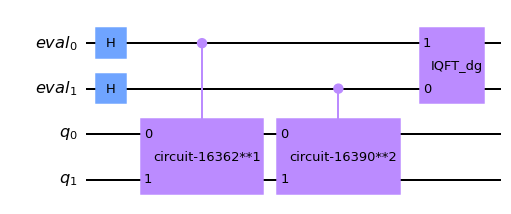

In [40]:
#PE circuit
pe = PhaseEstimation(resolution, u_circuit, name = "PE")
pe.decompose().draw("mpl")

# Check Statevector

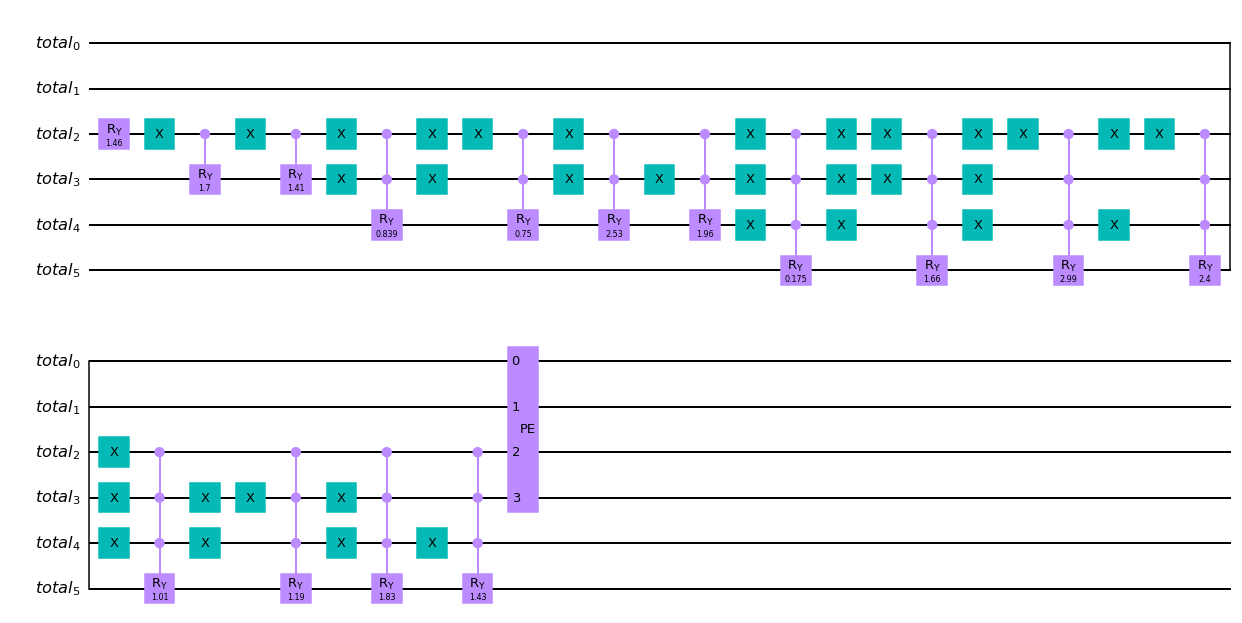

In [41]:
tot_qubit = resolution+len(example_matrix)

qr_total = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit = QuantumCircuit(qr_total , name='matrix')

total_circuit.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit.append(pe.to_gate(), qr_total[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit.swap(qr_total[0],qr_total[1])
#total_circuit.measure_all()

total_circuit.decompose(reps=1).draw("mpl")

In [42]:
backend_total = Aer.get_backend("statevector_simulator")
job = backend_total.run(transpile(total_circuit, backend=backend_total))
statevector = np.asarray(job.result().get_statevector()).round(4)
#plot_histogram(counts)

In [43]:
def attach_bitstrings(vector):
    return list(zip(bitstrings, vector))

In [44]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix))))]
ss=attach_bitstrings(statevector)
ss

[('000000', (-0.0001-0j)),
 ('000001', (0.1122+0j)),
 ('000010', (0.2003+0j)),
 ('000011', (0.1339-0j)),
 ('000100', (-0.0001+0j)),
 ('000101', (-0.1374-0j)),
 ('000110', (0.1147+0j)),
 ('000111', (0.158-0j)),
 ('001000', (-0.0002+0j)),
 ('001001', (0.0348+0j)),
 ('001010', (-0.1941-0j)),
 ('001011', (0.1985-0j)),
 ('001100', (0.0003+0j)),
 ('001101', (-0.0012+0j)),
 ('001110', (-0.035+0j)),
 ('001111', (0.1831-0j)),
 ('010000', (-0.0108+0j)),
 ('010001', (-0.1297-0j)),
 ('010010', (0.107+0j)),
 ('010011', (0.1687+0j)),
 ('010100', (-0.0174+0j)),
 ('010101', (0.1589+0j)),
 ('010110', (0.0613-0j)),
 ('010111', (0.199-0j)),
 ('011000', (-0.0318+0j)),
 ('011001', (-0.0402-0j)),
 ('011010', (-0.1037+0j)),
 ('011011', (0.25-0j)),
 ('011100', (0.0573-0j)),
 ('011101', (0.0014+0j)),
 ('011110', (-0.0187+0j)),
 ('011111', (0.2306-0j)),
 ('100000', (0.0166+0j)),
 ('100001', (0.0413+0j)),
 ('100010', (-0.1982+0j)),
 ('100011', (0.1794-0j)),
 ('100100', (0.0267+0j)),
 ('100101', (-0.0505+0j)),
 (

In [45]:
a=[i[1] for i in ss if i[0][-2:]=='11']
aa=np.array(a)
aa

array([0.1339-0.j, 0.158 -0.j, 0.1985-0.j, 0.1831-0.j, 0.1687+0.j,
       0.199 -0.j, 0.25  -0.j, 0.2306-0.j, 0.1794-0.j, 0.2117-0.j,
       0.266 -0.j, 0.2453-0.j, 0.166 -0.j, 0.1959-0.j, 0.2461-0.j,
       0.227 -0.j])

In [46]:
nf=np.sqrt((1/(sum(aa**2))))
aa*=nf
aa

array([0.16172318+0.j, 0.19083093+0.j, 0.23974646+0.j, 0.22114648+0.j,
       0.20375429+0.j, 0.24035035+0.j, 0.30194768+0.j, 0.27851654+0.j,
       0.21667765+0.j, 0.25568929+0.j, 0.32127233+0.j, 0.29627106+0.j,
       0.20049326+0.j, 0.2366062 +0.j, 0.29723729+0.j, 0.27416849+0.j])

# Computing Probabilities

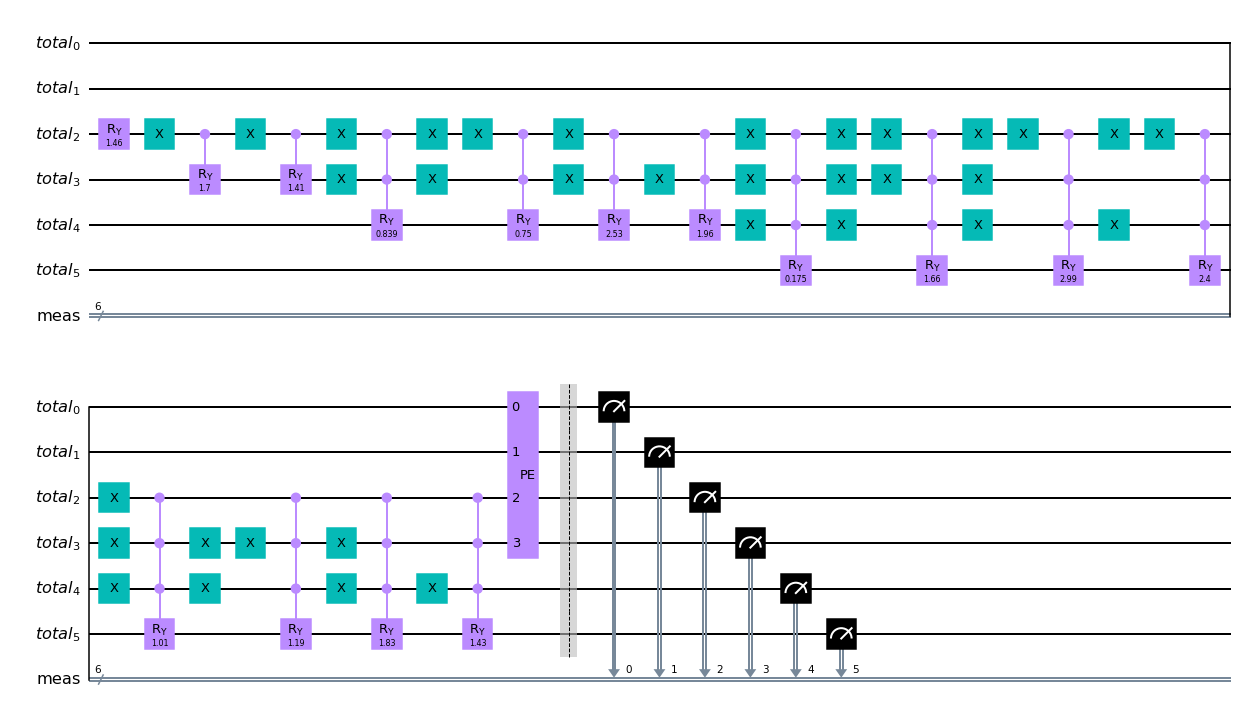

In [47]:
tot_qubit = resolution+len(example_matrix)

qr_total = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit_1 = QuantumCircuit(qr_total , name='matrix')

total_circuit_1.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit_1.append(pe.to_gate(), qr_total[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit_1.swap(qr_total[0],qr_total[1])
total_circuit_1.measure_all()

total_circuit_1.decompose(reps=1).draw("mpl")

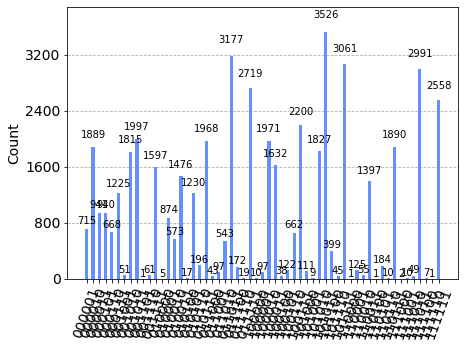

In [48]:
n_shots=50000
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_1, backend=backend_total), shots=n_shots)
counts = job.result().get_counts()
plot_histogram(counts)

# Storing probabilities

In [49]:
for i in counts:
    counts[i]/=n_shots
counts

{'110100': 2e-05,
 '001101': 2e-05,
 '110000': 2e-05,
 '111000': 4e-05,
 '111110': 2e-05,
 '100000': 0.0002,
 '100100': 0.00076,
 '010100': 0.00034,
 '011110': 0.00038,
 '001011': 0.03994,
 '011011': 0.06354,
 '001001': 0.00102,
 '101110': 0.0009,
 '000101': 0.0188,
 '110001': 0.0025,
 '110111': 0.0378,
 '011001': 0.00194,
 '001111': 0.03194,
 '110101': 0.00368,
 '100001': 0.00194,
 '111001': 0.0002,
 '101111': 0.06122,
 '011100': 0.00344,
 '010010': 0.01146,
 '101010': 0.03654,
 '101001': 0.00018,
 '100111': 0.044,
 '101100': 0.00798,
 '000011': 0.01882,
 '011000': 0.00086,
 '111100': 0.00014,
 '111010': 0.00098,
 '010111': 0.03936,
 '010001': 0.01748,
 '010110': 0.00392,
 '100011': 0.03264,
 '101011': 0.07052,
 '110010': 0.0011,
 '011010': 0.01086,
 '100101': 0.00244,
 '000001': 0.0143,
 '010000': 0.0001,
 '100110': 0.01324,
 '001110': 0.00122,
 '010011': 0.02952,
 '010101': 0.0246,
 '110110': 0.0002,
 '000010': 0.03778,
 '111011': 0.05982,
 '100010': 0.03942,
 '111111': 0.05116,
 '1

In [50]:
statevector=np.zeros(2**tot_qubit)
for i in counts:
    statevector[int(i,2)]=counts[i]
statevector

array([0.000e+00, 1.430e-02, 3.778e-02, 1.882e-02, 0.000e+00, 1.880e-02,
       1.336e-02, 2.450e-02, 0.000e+00, 1.020e-03, 3.630e-02, 3.994e-02,
       0.000e+00, 2.000e-05, 1.220e-03, 3.194e-02, 1.000e-04, 1.748e-02,
       1.146e-02, 2.952e-02, 3.400e-04, 2.460e-02, 3.920e-03, 3.936e-02,
       8.600e-04, 1.940e-03, 1.086e-02, 6.354e-02, 3.440e-03, 0.000e+00,
       3.800e-04, 5.438e-02, 2.000e-04, 1.940e-03, 3.942e-02, 3.264e-02,
       7.600e-04, 2.440e-03, 1.324e-02, 4.400e-02, 2.220e-03, 1.800e-04,
       3.654e-02, 7.052e-02, 7.980e-03, 0.000e+00, 9.000e-04, 6.122e-02,
       2.000e-05, 2.500e-03, 1.100e-03, 2.794e-02, 2.000e-05, 3.680e-03,
       2.000e-04, 3.780e-02, 4.000e-05, 2.000e-04, 9.800e-04, 5.982e-02,
       1.400e-04, 0.000e+00, 2.000e-05, 5.116e-02])

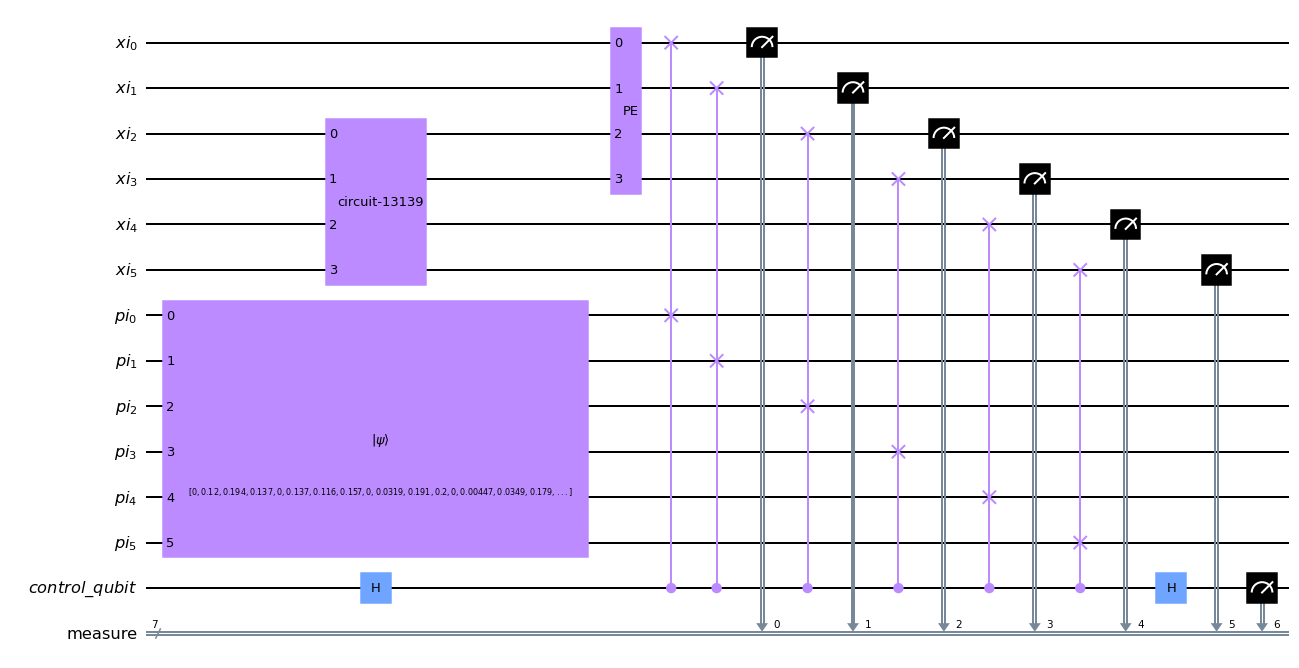

In [51]:

tot_qubit = resolution+len(example_matrix)

qr_total_xi = QuantumRegister(tot_qubit, 'xi')
qr_total_pi = QuantumRegister(tot_qubit, 'pi')
qr_control = QuantumRegister(1, 'control_qubit')
n_classical_register=tot_qubit+1
classical = ClassicalRegister(n_classical_register, 'measure')

total_circuit_2 = QuantumCircuit(qr_total_xi,qr_total_pi,qr_control ,classical, name='matrix')

total_circuit_2.append(matrix_circuit.to_gate(), qr_total_xi[resolution:])
total_circuit_2.append(pe.to_gate(), qr_total_xi[0:pe.num_qubits])

#total_circuit_2.swap(qr_total_xi[0],qr_total_xi[1])
total_circuit_2.initialize(np.sqrt(statevector),qr_total_pi)
total_circuit_2.h(qr_control)
for i in range(tot_qubit):
    total_circuit_2.cswap(control_qubit=qr_control, target_qubit1=qr_total_xi[i],target_qubit2=qr_total_pi[i])

total_circuit_2.h(qr_control)
total_circuit_2.measure(qr_total_xi,classical[0:n_classical_register-1])
total_circuit_2.measure(qr_control,classical[n_classical_register-1])

total_circuit_2.draw("mpl")

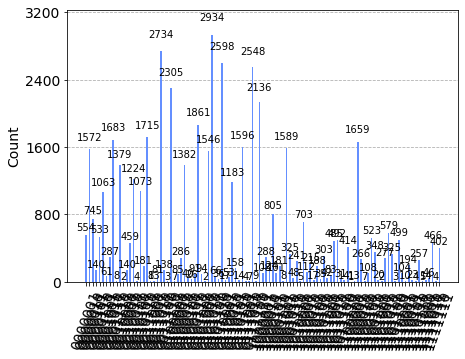

In [52]:
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_2, backend=backend_total), shots=n_shots)
counts_for_sign = job.result().get_counts()
plot_histogram(counts_for_sign)

In [53]:
#Take only counts with control qubits equal to 0
tmp=np.zeros(2**tot_qubit)
for c in counts_for_sign:
    if c[0]=='0':
        tmp[int(c[1:],2)]=counts_for_sign[c]
tmp

array([0.000e+00, 5.540e+02, 1.572e+03, 7.450e+02, 0.000e+00, 1.400e+02,
       5.330e+02, 1.063e+03, 0.000e+00, 6.100e+01, 2.870e+02, 1.683e+03,
       0.000e+00, 0.000e+00, 8.000e+00, 1.379e+03, 2.000e+00, 1.400e+02,
       4.590e+02, 1.224e+03, 4.000e+00, 1.073e+03, 1.810e+02, 1.715e+03,
       8.000e+00, 1.300e+01, 8.100e+01, 2.734e+03, 1.380e+02, 0.000e+00,
       3.000e+00, 2.305e+03, 7.000e+00, 8.500e+01, 2.860e+02, 1.382e+03,
       4.000e+01, 2.600e+01, 9.100e+01, 1.861e+03, 9.400e+01, 2.000e+00,
       1.546e+03, 2.934e+03, 6.600e+01, 0.000e+00, 3.600e+01, 2.598e+03,
       0.000e+00, 1.700e+01, 5.300e+01, 1.183e+03, 0.000e+00, 1.580e+02,
       1.400e+01, 1.596e+03, 0.000e+00, 4.000e+00, 7.000e+00, 2.548e+03,
       9.000e+00, 0.000e+00, 0.000e+00, 2.136e+03])

In [54]:
statevector

array([0.000e+00, 1.430e-02, 3.778e-02, 1.882e-02, 0.000e+00, 1.880e-02,
       1.336e-02, 2.450e-02, 0.000e+00, 1.020e-03, 3.630e-02, 3.994e-02,
       0.000e+00, 2.000e-05, 1.220e-03, 3.194e-02, 1.000e-04, 1.748e-02,
       1.146e-02, 2.952e-02, 3.400e-04, 2.460e-02, 3.920e-03, 3.936e-02,
       8.600e-04, 1.940e-03, 1.086e-02, 6.354e-02, 3.440e-03, 0.000e+00,
       3.800e-04, 5.438e-02, 2.000e-04, 1.940e-03, 3.942e-02, 3.264e-02,
       7.600e-04, 2.440e-03, 1.324e-02, 4.400e-02, 2.220e-03, 1.800e-04,
       3.654e-02, 7.052e-02, 7.980e-03, 0.000e+00, 9.000e-04, 6.122e-02,
       2.000e-05, 2.500e-03, 1.100e-03, 2.794e-02, 2.000e-05, 3.680e-03,
       2.000e-04, 3.780e-02, 4.000e-05, 2.000e-04, 9.800e-04, 5.982e-02,
       1.400e-04, 0.000e+00, 2.000e-05, 5.116e-02])

In [55]:
#Sign estimation
sign_dictionary={}
sign=0
for e, (count, prob) in enumerate(zip(tmp, statevector)):
    if count>0.4*prob*n_shots:
        sign=1
    else:
        sign=-1
    if prob==0:
        sign=0
    sign_dictionary.update({bin(e)[2:].zfill(tot_qubit):sign})

In [56]:
sign_dictionary

{'000000': 0,
 '000001': 1,
 '000010': 1,
 '000011': 1,
 '000100': 0,
 '000101': -1,
 '000110': 1,
 '000111': 1,
 '001000': 0,
 '001001': 1,
 '001010': -1,
 '001011': 1,
 '001100': 0,
 '001101': -1,
 '001110': -1,
 '001111': 1,
 '010000': -1,
 '010001': -1,
 '010010': 1,
 '010011': 1,
 '010100': -1,
 '010101': 1,
 '010110': 1,
 '010111': 1,
 '011000': -1,
 '011001': -1,
 '011010': -1,
 '011011': 1,
 '011100': 1,
 '011101': 0,
 '011110': -1,
 '011111': 1,
 '100000': 1,
 '100001': 1,
 '100010': -1,
 '100011': 1,
 '100100': 1,
 '100101': -1,
 '100110': -1,
 '100111': 1,
 '101000': 1,
 '101001': -1,
 '101010': 1,
 '101011': 1,
 '101100': -1,
 '101101': 0,
 '101110': 1,
 '101111': 1,
 '110000': -1,
 '110001': -1,
 '110010': 1,
 '110011': 1,
 '110100': -1,
 '110101': 1,
 '110110': 1,
 '110111': 1,
 '111000': -1,
 '111001': -1,
 '111010': -1,
 '111011': 1,
 '111100': 1,
 '111101': 0,
 '111110': -1,
 '111111': 1}

In [57]:
statevector_dictionary={}
for e,key in enumerate(sign_dictionary):
    statevector_dictionary[key]=sign_dictionary[key]*np.sqrt(statevector[e])

statevector_dictionary

{'000000': 0.0,
 '000001': 0.11958260743101398,
 '000010': 0.1943707796969493,
 '000011': 0.13718600511714013,
 '000100': 0.0,
 '000101': -0.13711309200802088,
 '000110': 0.11558546621439912,
 '000111': 0.15652475842498528,
 '001000': 0.0,
 '001001': 0.03193743884534263,
 '001010': -0.1905255888325765,
 '001011': 0.19984994370777293,
 '001100': 0.0,
 '001101': -0.00447213595499958,
 '001110': -0.03492849839314596,
 '001111': 0.17871765441612086,
 '010000': -0.01,
 '010001': -0.13221195104830727,
 '010010': 0.10705138952858108,
 '010011': 0.17181385275931624,
 '010100': -0.018439088914585774,
 '010101': 0.15684387141358122,
 '010110': 0.06260990336999411,
 '010111': 0.1983935482821959,
 '011000': -0.02932575659723036,
 '011001': -0.044045431091090485,
 '011010': -0.10421132376090422,
 '011011': 0.25207141845120007,
 '011100': 0.05865151319446072,
 '011101': 0.0,
 '011110': -0.019493588689617928,
 '011111': 0.23319519720611742,
 '100000': 0.01414213562373095,
 '100001': 0.044045431091090

# Eigenvectors reconstruction (2x2 matrix)


In [58]:
binary_lambda=[]
for d in statevector_dictionary:
    if statevector_dictionary[d]!=0:
        binary_lambda.append(d[-resolution:])
l_list=[]
eigenvalues=[]
for b_l in np.unique(binary_lambda):
    eigenvalues.append(int(b_l[::-1],2))
    tmp_list=[]
    for key in list(statevector_dictionary.keys()):
        if key[-resolution:]==b_l:
            tmp_list.append(statevector_dictionary[key])
    l_list.append(np.asarray(tmp_list))
l_list

[array([ 0.        ,  0.        ,  0.        ,  0.        , -0.01      ,
        -0.01843909, -0.02932576,  0.05865151,  0.01414214,  0.0275681 ,
         0.04711688, -0.08933085, -0.00447214, -0.00447214, -0.00632456,
         0.01183216]),
 array([ 0.11958261, -0.13711309,  0.03193744, -0.00447214, -0.13221195,
         0.15684387, -0.04404543,  0.        ,  0.04404543, -0.04939636,
        -0.01341641,  0.        , -0.05      ,  0.060663  , -0.01414214,
         0.        ]),
 array([ 0.19437078,  0.11558547, -0.19052559, -0.0349285 ,  0.10705139,
         0.0626099 , -0.10421132, -0.01949359, -0.19854471, -0.1150652 ,
         0.19115439,  0.03      ,  0.03316625,  0.01414214, -0.03130495,
        -0.00447214]),
 array([0.13718601, 0.15652476, 0.19984994, 0.17871765, 0.17181385,
        0.19839355, 0.25207142, 0.2331952 , 0.18066544, 0.20976177,
        0.26555602, 0.24742676, 0.16715262, 0.19442222, 0.24458127,
        0.22618576])]

In [59]:
for l in l_list:
    normalization_factor=np.sqrt((1/(sum(l**2))))
    l*=normalization_factor

# Non eseguire le prossime celle-> si riferiscono ai conti fatti dopo

In [251]:
l_list

[array([ 0.02487923, -0.18736271,  0.01880693,  0.05719904, -0.10680283,
         0.909369  , -0.09862437, -0.31413765, -0.01628728,  0.08669566,
         0.        , -0.03118776,  0.        ,  0.06649254, -0.00940346,
        -0.02487923]),
 array([ 0.88370213,  0.07377497, -0.4228159 ,  0.03393155,  0.01772018,
         0.        ,  0.        ,  0.        ,  0.14395938,  0.01023075,
        -0.05877117, -0.01023075,  0.08681077,  0.        , -0.03688749,
        -0.01023075]),
 array([ 0.16746511, -0.07463575,  0.2775365 , -0.3508948 , -0.15862936,
         0.06789746, -0.29854301,  0.3754879 , -0.08081414,  0.04157853,
        -0.13148287,  0.16162829, -0.21336447,  0.11428846, -0.37497599,
         0.50544481]),
 array([0.10582468, 0.11233706, 0.25719353, 0.21691459, 0.1532455 ,
        0.16856757, 0.38357703, 0.33125843, 0.09255428, 0.09803553,
        0.22772225, 0.18934909, 0.1831797 , 0.20604706, 0.4646188 ,
        0.39553735])]

In [253]:
np.linalg.eig(example_matrix)

(array([3.00000000e+00, 2.00000000e+00, 1.00000000e+00, 1.38840214e-16]),
 array([[-0.27283206, -0.89909441,  0.32289714,  0.11370725],
        [-0.30415742, -0.07818057, -0.14423829, -0.93838765],
        [-0.69638872,  0.42791917,  0.56686168,  0.1029358 ],
        [-0.58999464, -0.04901247, -0.74404341,  0.30968291]]))

$$\left|11\right\rangle(0.1058|0000\rangle+0.1123|0001\rangle+0.2571|0010\rangle+0.2169|0011\rangle+
0.1532|0100\rangle+0.1685|0101\rangle+0.3835|0110\rangle+0.3312|0111\rangle+0.09255|1000\rangle+0.09803|1001\rangle+0.2277|1010\rangle+0.1893|1011\rangle+
0.1831|1100\rangle+0.2060|1101\rangle+0.4646|1110\rangle+0.3955|1111\rangle) =$$

$$\left|11\right\rangle\left[\textbf{0.2571|00}\rangle(0.41|00\rangle+0.43|01\rangle+|10\rangle+0.84|11\rangle)+\\
\textbf{0.3835|01}\rangle(0.399|00\rangle+0.48|01\rangle+|10\rangle+0.86|11\rangle)+\\
\textbf{0.2277|01}\rangle(0.40|00\rangle+0.43|01\rangle+|10\rangle+0.83|11\rangle)+\\
\textbf{0.4646|01}\rangle(0.39|00\rangle+0.44|01\rangle+|10\rangle+0.8|11\rangle)\right]\\
$$

$$\sqrt{0.4646}=0.68 -> 3 posizione 
\\
0.68*0.39=0.265-> 1 posizione
\\
0.68*0.44=0.29 -> 2 posizione
\\
0.68*0.8=0.54 -> 4 posizione
$$




$$\left|10\right\rangle(0.1674|0000\rangle-0.0746|0001\rangle+0.27753|0010\rangle-0.3508|0011\rangle-0.1586|0100\rangle+0.06789|0101\rangle-0.2985|0110\rangle+0.3754|0111\rangle-0.08081|1000\rangle+0.04157|1001\rangle-0.1314|1010\rangle+0.1616|1011\rangle-0.2133|1100\rangle+0.11428|1101\rangle-0.3749|1110\rangle+0.50544|1111\rangle) =$$


$$\left|10\right\rangle\left[\textbf{0.3508|00}\rangle(0.4771|00\rangle-0.2126|01\rangle+0.7911|10\rangle-|11\rangle)-\\
\textbf{0.3754|01}\rangle(0.4224|00\rangle-0.187|01\rangle+0.7951|10\rangle-|11\rangle)-\\
\textbf{0.1616|10}\rangle(0.50|00\rangle-0.26|01\rangle+0.8131|10\rangle-|11\rangle)-\\
\textbf{0.50544|10}\rangle(0.42|00\rangle-0.22|01\rangle+0.75|10\rangle-|11\rangle)\right]=
$$


$$
\sqrt{0.50544}=\approx0.71 -> 4 posizione 
\\
0.71*0.42=0.29-> 1 posizione
\\
0.68*0.22=0.15 -> 2 posizione
\\
0.68*0.75=... -> 3 posizione
$$

Magari possiamo fare una media dei vari rapporti. Per esempio: (0.4771+0.4224+0.50+0.42)/4=x. Dopodichè moltiplicare la radice del massimo dei massimi (0.71 in quest'ultimo caso) per x invece che per 0.42 per trovare il valore della prima posizione dell'eigenvector.

Prendiamo sempre il massimo dei massimi perchè è quello che viene influenzato meno da eventuali errori di approssimazione (?)





In [284]:
l_list

[array([0.4241215 , 0.61471659, 0.37664376, 0.54807294]),
 array([ 0.81858522, -0.56242645, -0.09622978,  0.06583729])]

In [285]:
np.linalg.eig(example_matrix)

(array([3., 1.]),
 array([[ 0.82363923,  0.56711412],
        [-0.56711412,  0.82363923]]))

$$\left|10\right\rangle(0.4241|00\rangle+0.6147|01\rangle+0.3766|10\rangle+0.5480|11\rangle) =$$

$$\left|10\right\rangle(0.6147|0\rangle(0.689|0\rangle+|1\rangle)+0.5480|1\rangle(0.687|0\rangle+|1\rangle)) =$$

$$\sqrt{0.6147}=0.7840 -> posizione 1$$ 

$$0.7840*0.689=0.5401 -> posizione 0$$




# Eigenvectors Reconstruction (Generalized)

In [60]:
#TODO: Capire se fare la media tra i vari fattori di rescaling
eigenvectors=[]
for ll, eig in zip(l_list,eigenvalues):
    #print(ll,eig)
    eigenvector=np.zeros(len(example_matrix)) #put length of eigenvector
    save_sign=np.sign(ll)
    statevector=abs(ll)
    max_list=[]
    scaled_statevectors=[]
    for e,i in enumerate(range(0,len(statevector),len(example_matrix))):
        max_list.append(max(statevector[i:i+len(example_matrix)]))
        scaled_statevectors.append(statevector[i:i+len(example_matrix)]/max_list[e])
        #print(max_list,scaled_statevectors)
    idx_max=np.argmax(max_list)
    #print(idx_max)
    max_max=max_list[idx_max]
    #print(max_max)
    value=np.sqrt(max_max)
    eigenvector=scaled_statevectors[idx_max]*value*save_sign[:len(example_matrix)]
    eigenvectors.append(eigenvector)
    print(eigenvector)
    print('eigenvalue:', eig)
    

[0. 0. 0. 0.]
eigenvalue: 0
[ 0.611037   -0.72487705  0.20356245 -0.        ]
eigenvalue: 2
[ 0.66005555  0.38253059 -0.63548667 -0.09973404]
eigenvalue: 1
[0.38507206 0.44708827 0.56600868 0.52736779]
eigenvalue: 3


/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_5286/1929885127.py:12: RuntimeWarning: invalid value encountered in divide
  scaled_statevectors.append(statevector[i:i+len(example_matrix)]/max_list[e])


In [61]:
np.linalg.eig(example_matrix)

(array([3.00000000e+00, 2.00000000e+00, 1.00000000e+00, 1.17985385e-16]),
 array([[-0.39348026,  0.62061258,  0.6597444 , -0.15732338],
        [-0.46422504, -0.76009576,  0.37781167, -0.2529978 ],
        [-0.58326885,  0.19248217, -0.6392686 , -0.46269183],
        [-0.53802031, -0.00671381, -0.1154614 ,  0.83495972]]))

## 1st matrix_example

In [501]:
norm_up=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_up_threshold.values()))**2))))
norm_down=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_down_threshold.values()))**2))))
for k in statevector_dictionary_up_threshold:
    statevector_dictionary_up_threshold[k]*=norm_up
    
    
for k_d in statevector_dictionary_down_threshold:
    statevector_dictionary_down_threshold[k_d]*=norm_down
statevector_dictionary_up_threshold,statevector_dictionary_down_threshold, np.linalg.eig(example_matrix)

({'0001': 0.4063074844837685,
  '0101': -0.4947759382402847,
  '1001': -0.48985675123506794,
  '1101': 0.5917358889406178},
 {'0011': 0.5898840122966107,
  '0111': 0.49452547412185405,
  '1011': 0.4915537016695547,
  '1111': 0.4072546695329175},
 (array([3., 1.]),
  array([[ 0.76746056, -0.64109616],
         [ 0.64109616,  0.76746056]])))

$$\left|01\right\rangle(0.4063|00\rangle-0.4947|01\rangle-0.4898|10\rangle+0.5917|11\rangle) =$$

$$\left|01\right\rangle(0.4063|0\rangle(|0\rangle-1.21|1\rangle)-0.4898|1\rangle(|0\rangle-x|1\rangle)) =$$

$$\left|01\right\rangle((0.4063|0\rangle-0.4898|1\rangle)(|0\rangle-x|1\rangle)) =$$

$$\left|01\right\rangle(0.4063(|0\rangle-y|1\rangle)(|0\rangle-x|1\rangle)) =>$$

$$\sqrt{0.5917}=0.7692$$

$$0.7692*\approx0.8*\text{sign}\left|1\right\rangle=-0.6153$$




$$\left|11\right\rangle(0.5898|00\rangle+0.4945|01\rangle+0.4915|10\rangle+0.4072|11\rangle) =$$

$$\left|11\right\rangle(0.5898|0\rangle(|0\rangle+0.83|1\rangle)+0.4915|1\rangle(|0\rangle+0.83|1\rangle)) =$$

$$\left|11\right\rangle((0.5898|0\rangle+0.4915|1\rangle)(|0\rangle+0.83|1\rangle)) =$$

$$\left|11\right\rangle(0.5898(|0\rangle+0.83|1\rangle)(|0\rangle+0.83|1\rangle)) =>$$

$$\sqrt{0.5898}=0.7679$$

$$0.7679*\approx0.8*\text{sign}\left|0\right\rangle=0.6143$$




## 2nd matrix_example

$$\left|01\right\rangle(0.1272|00\rangle-0.3143|01\rangle-0.3203|10\rangle+0.8845|11\rangle) =$$

$$\left|01\right\rangle(0.3143|0\rangle(0.40|0\rangle-|1\rangle)-0.8845|1\rangle(0.36|0\rangle-|1\rangle)) =$$

$$\left|01\right\rangle((0.3143|0\rangle-0.8845|1\rangle)(0.4|0\rangle-|1\rangle)) =$$

$$\left|01\right\rangle(0.8845(0.36|0\rangle-|1\rangle)(0.4|0\rangle-|1\rangle)) =>$$

$$\sqrt{0.8845}=0.9404$$

$$0.9404*\approx0.4*\text{sign}\left|1\right\rangle=-0.3761$$




## 3d matrix_example

In [643]:
norm_up=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_up_threshold.values()))**2))))
norm_down=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_down_threshold.values()))**2))))
for k in statevector_dictionary_up_threshold:
    statevector_dictionary_up_threshold[k]*=norm_up
    
    
for k_d in statevector_dictionary_down_threshold:
    statevector_dictionary_down_threshold[k_d]*=norm_down
statevector_dictionary_up_threshold,statevector_dictionary_down_threshold, np.linalg.eig(example_matrix)

({'0001': 0.36710092124099825,
  '0101': 0.6614992335357107,
  '1001': 0.3149078628268718,
  '1101': 0.5731393509308969},
 {'0011': 0.8721533545579773,
  '0111': -0.4889160360072559,
  '1011': 0.013630169512202875,
  '1111': -0.011128986804178979},
 (array([3., 1.]),
  array([[ 0.87370608,  0.4864542 ],
         [-0.4864542 ,  0.87370608]])))

$$\left|01\right\rangle(0.3671|00\rangle+0.6614|01\rangle+0.3149|10\rangle+0.5731|11\rangle) =$$

$$\left|01\right\rangle(0.6614|0\rangle(0.55|0\rangle+|1\rangle)+0.5731|1\rangle(0.55|0\rangle+|1\rangle)) =$$

$$\left|01\right\rangle((0.6614|0\rangle+0.5731|1\rangle)(0.55|0\rangle+|1\rangle)) =$$

$$\left|01\right\rangle(0.6614(|0\rangle+\approx0.8|1\rangle)(0.55|0\rangle-|1\rangle)) =>$$

$$\sqrt{0.6614}=\approx0.81$$

$$0.81*\approx0.55*\text{sign}\left|1\right\rangle=\approx0.44$$




$$\left|11\right\rangle(0.8721|00\rangle-0.4889|01\rangle+0.0136|10\rangle-0.0111|11\rangle) =$$

$$\left|11\right\rangle(0.8721|0\rangle(|0\rangle-\approx0.5|1\rangle)+0.0136|1\rangle(|0\rangle-\approx0.8|1\rangle)) =$$

$$\left|11\right\rangle((0.8721|0\rangle+0.0136|1\rangle)(|0\rangle-\approx0.5|1\rangle)) =$$

$$\left|11\right\rangle(0.8721(|0\rangle+0.0155|1\rangle)(|0\rangle-0.5|1\rangle)) =>$$

$$\sqrt{0.8721}=\approx0.93$$

$$0.93*\approx0.5*\text{sign}\left|0\right\rangle=\approx0.44$$




## 4th matrix_example

In [672]:
norm_up=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_up_threshold.values()))**2))))
norm_down=np.sqrt((1/(sum(np.asarray(list(statevector_dictionary_down_threshold.values()))**2))))
for k in statevector_dictionary_up_threshold:
    statevector_dictionary_up_threshold[k]*=norm_up
    
    
for k_d in statevector_dictionary_down_threshold:
    statevector_dictionary_down_threshold[k_d]*=norm_down
statevector_dictionary_up_threshold,statevector_dictionary_down_threshold, np.linalg.eig(example_matrix)

({'0001': 0.06844207564752064,
  '0101': -0.2434477406836873,
  '1001': -0.26237207143606917,
  '1101': 0.9312409870529826},
 {'0011': 0.9317470599478411,
  '0111': 0.2529050552183149,
  '1011': 0.251498062074687,
  '1111': 0.06808211289503242},
 (array([3., 1.]),
  array([[ 0.96521162, -0.26146994],
         [ 0.26146994,  0.96521162]])))

$$\left|11\right\rangle(0.93|00\rangle+0.25|01\rangle+0.25|10\rangle+0.068|11\rangle) =$$

$$\left|11\right\rangle(0.93|0\rangle(|0\rangle+\approx0.26|1\rangle)+0.25|1\rangle(|0\rangle+0.2|1\rangle)) =$$

$$\left|11\right\rangle((0.93|0\rangle+0.25|1\rangle)(|0\rangle+\approx0.2|1\rangle)) =$$

$$\left|11\right\rangle(0.93(|0\rangle+0.2|1\rangle)(|0\rangle+0.2|1\rangle)) =>$$

$$\sqrt{0.93}=\approx0.96$$

$$0.96*\approx0.2*\text{sign}\left|0\right\rangle=\approx0.25$$


